In [1]:
import numpy as np
import pandas as pd
from numba import njit
from pandas.api.types import is_datetime64_any_dtype

@njit
def CBS(row):
    """consolidated bid size"""
    col = row.copy() * -1
    col[col <= 0] = 0
    diff = np.abs(np.diff(col))
    return np.sum(diff) + col[0]
@njit
def CAS(row):
    """consolidated ask size"""
    col = row.copy()
    col[col <= 0] = 0
    diff = np.abs(np.diff(col))
    return np.sum(diff) + col[0]
@njit
def TCBS(cbs):
    """total consolidated bid size"""
    return np.sum(cbs)
@njit
def TCAS(cas):
    """total consolidated ask size"""
    return np.sum(cas)
@njit
def WBP(cbs):
    """weighted bid price"""
    tcbs = TCBS(cbs)
    wbp = 0
    for p, cbsi in enumerate(cbs):
        wbp += (p+1) * (cbsi / tcbs)
    return wbp
@njit
def WAP(cas):
    """weighted bid price"""
    tcas = TCAS(cas)
    wbp = 0
    for p, casi in enumerate(cas):
        wbp += (p+1) * (casi / tcas)
    return wbp
@njit
def AWS(row):
    """actvity weighted spread"""
    return WAP(row) - WBP(row)

def AP(tapes_segment):
    """average price"""
    pass

def AWR(tapes):
    """activity weighted return"""
    pass

def calculate_high_bid(sliced_arr):
    negative_indices = np.where(sliced_arr < 0, np.arange(sliced_arr.shape[1]), -1)
    max_negative_index = np.max(negative_indices, axis=1)
    high_bid = np.median(max_negative_index) + 1
    return high_bid

def calculate_low_ask(sliced_arr):
    positive_indices = np.where(sliced_arr > 0, np.arange(sliced_arr.shape[1]), 800)
    min_positive_index = np.min(positive_indices, axis=1)
    low_ask = np.median(min_positive_index) + 1
    return low_ask

def features(day_df, seg_length = "1m", vis=False):

    if not is_datetime64_any_dtype(day_df.index):
        print("converting index to datetime")
        day_df.index = pd.to_datetime(day_df.index)

    segment_length_options = {"1s": int(60*60*8.5), 
                              "5s": int(12*60*8.5), 
                              "10s": int(6*60*8.5),
                              "15s": int(4*60*8.5), 
                              "20s": int(3*60*8.5),
                              "30s": int(2*60*8.5),
                              "1m": int(60*8.5),
                              "2m": int(30*8.5),
                              "5m": int(12*8.5),
                              "10m": int(6*8.5), 
                              "30m": int(2*8.5)}
    
    if seg_length not in segment_length_options.keys():
        raise ValueError("Invalid segment length / step\nPlease pick from "+str(segment_length_options.keys()))
    
    rows = []
    arr = day_df.to_numpy()
    min_time = day_df.index[0]
    max_time = day_df.index[-1]
    start_time = min_time
    length_df = len(day_df)

    cbs_arr = np.zeros((segment_length_options[seg_length],800))
    cas_arr = np.zeros((segment_length_options[seg_length],800))

    i = 0
    start_index = 0
    while start_time < max_time:
        
        end_time = start_time + pd.Timedelta(seg_length)

        end_index = start_index

        while day_df.index[end_index] < end_time and end_index < length_df - 1:
            end_index += 1

        if vis:
            print(start_index, end_index)

        sliced_arr = arr[start_index:end_index]

        row = {"end_time": end_time}

        cbs_arr[i] = np.apply_along_axis(CBS, axis=0, arr = sliced_arr)
        cas_arr[i] = np.apply_along_axis(CAS, axis=0, arr = sliced_arr)
        row["TCBS"] = TCBS(cbs_arr[i])
        row["TCAS"] = TCAS(cas_arr[i])
        row["WBP"] = WBP(cbs_arr[i])
        row["WAP"] = WAP(cas_arr[i])
        row["AWS"] = row["WAP"] - row["WBP"]

        row["high_bid"] = calculate_high_bid(sliced_arr)
        row["low_ask"] = calculate_low_ask(sliced_arr)

        row["mid_price"] = (row["high_bid"] + row["low_ask"]) / 2
        row["spread"] = row["low_ask"] - row["high_bid"]

        rows.append(row)

        i += 1

        start_time = end_time
        start_index = end_index

    out_df = pd.DataFrame(rows)
    out_df.index = out_df["end_time"]
    out_df["WMP"] = (out_df["WBP"] + out_df["WAP"]) / 2
    out_df["TCBS-TCAS"] = out_df["TCBS"] - out_df["TCAS"]
    out_df["TA"] = out_df["TCBS"] + out_df["TCAS"]

    return out_df.drop(columns=["end_time"], axis = 1), cbs_arr, cas_arr

In [2]:
from tools import read_csr
data = read_csr(0)
df = data[0]

In [3]:
min_df, cbs_arr, cas_arr = features(df, seg_length="1m")
min_df

converting index to datetime


,TCBS,TCAS,WBP,WAP,AWS,high_bid,low_ask,mid_price,spread,WMP,TCBS-TCAS,TA
end_time,,,,,,,,,,,,
2024-03-10 08:01:00,2063.0,2030.0,174.047019,403.270443,229.223424,261.0,267.0,264.0,6.0,288.658731,33.0,4093.0
2024-03-10 08:02:00,3437.0,1610.0,160.941519,426.265217,265.323699,259.0,263.0,261.0,4.0,293.603368,1827.0,5047.0
2024-03-10 08:03:00,3345.0,1714.0,159.676831,457.617853,297.941022,263.0,267.0,265.0,4.0,308.647342,1631.0,5059.0
2024-03-10 08:04:00,1935.0,2094.0,196.065633,437.875836,241.810203,262.0,268.0,265.0,6.0,316.970734,-159.0,4029.0
2024-03-10 08:05:00,2536.0,2049.0,170.129732,431.920449,261.790717,262.0,269.0,265.5,7.0,301.025090,487.0,4585.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-10 16:26:00,2392.0,2039.0,192.063963,464.113291,272.049328,288.0,294.0,291.0,6.0,328.088627,353.0,4431.0
2024-03-10 16:27:00,2483.0,1491.0,203.424889,481.528504,278.103615,293.0,301.0,297.0,8.0,342.476697,992.0,3974.0
2024-03-10 16:28:00,2787.0,2086.0,164.380696,477.070949,312.690253,288.0,292.0,290.0,4.0,320.725823,701.0,4873.0


<Axes: xlabel='end_time'>

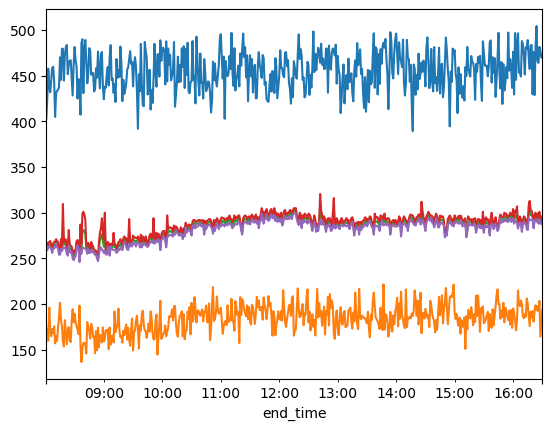

In [4]:
import matplotlib.pyplot as plt

min_df["WAP"].plot()
min_df["WBP"].plot()
min_df["mid_price"].plot()
min_df["low_ask"].plot()
min_df["high_bid"].plot()

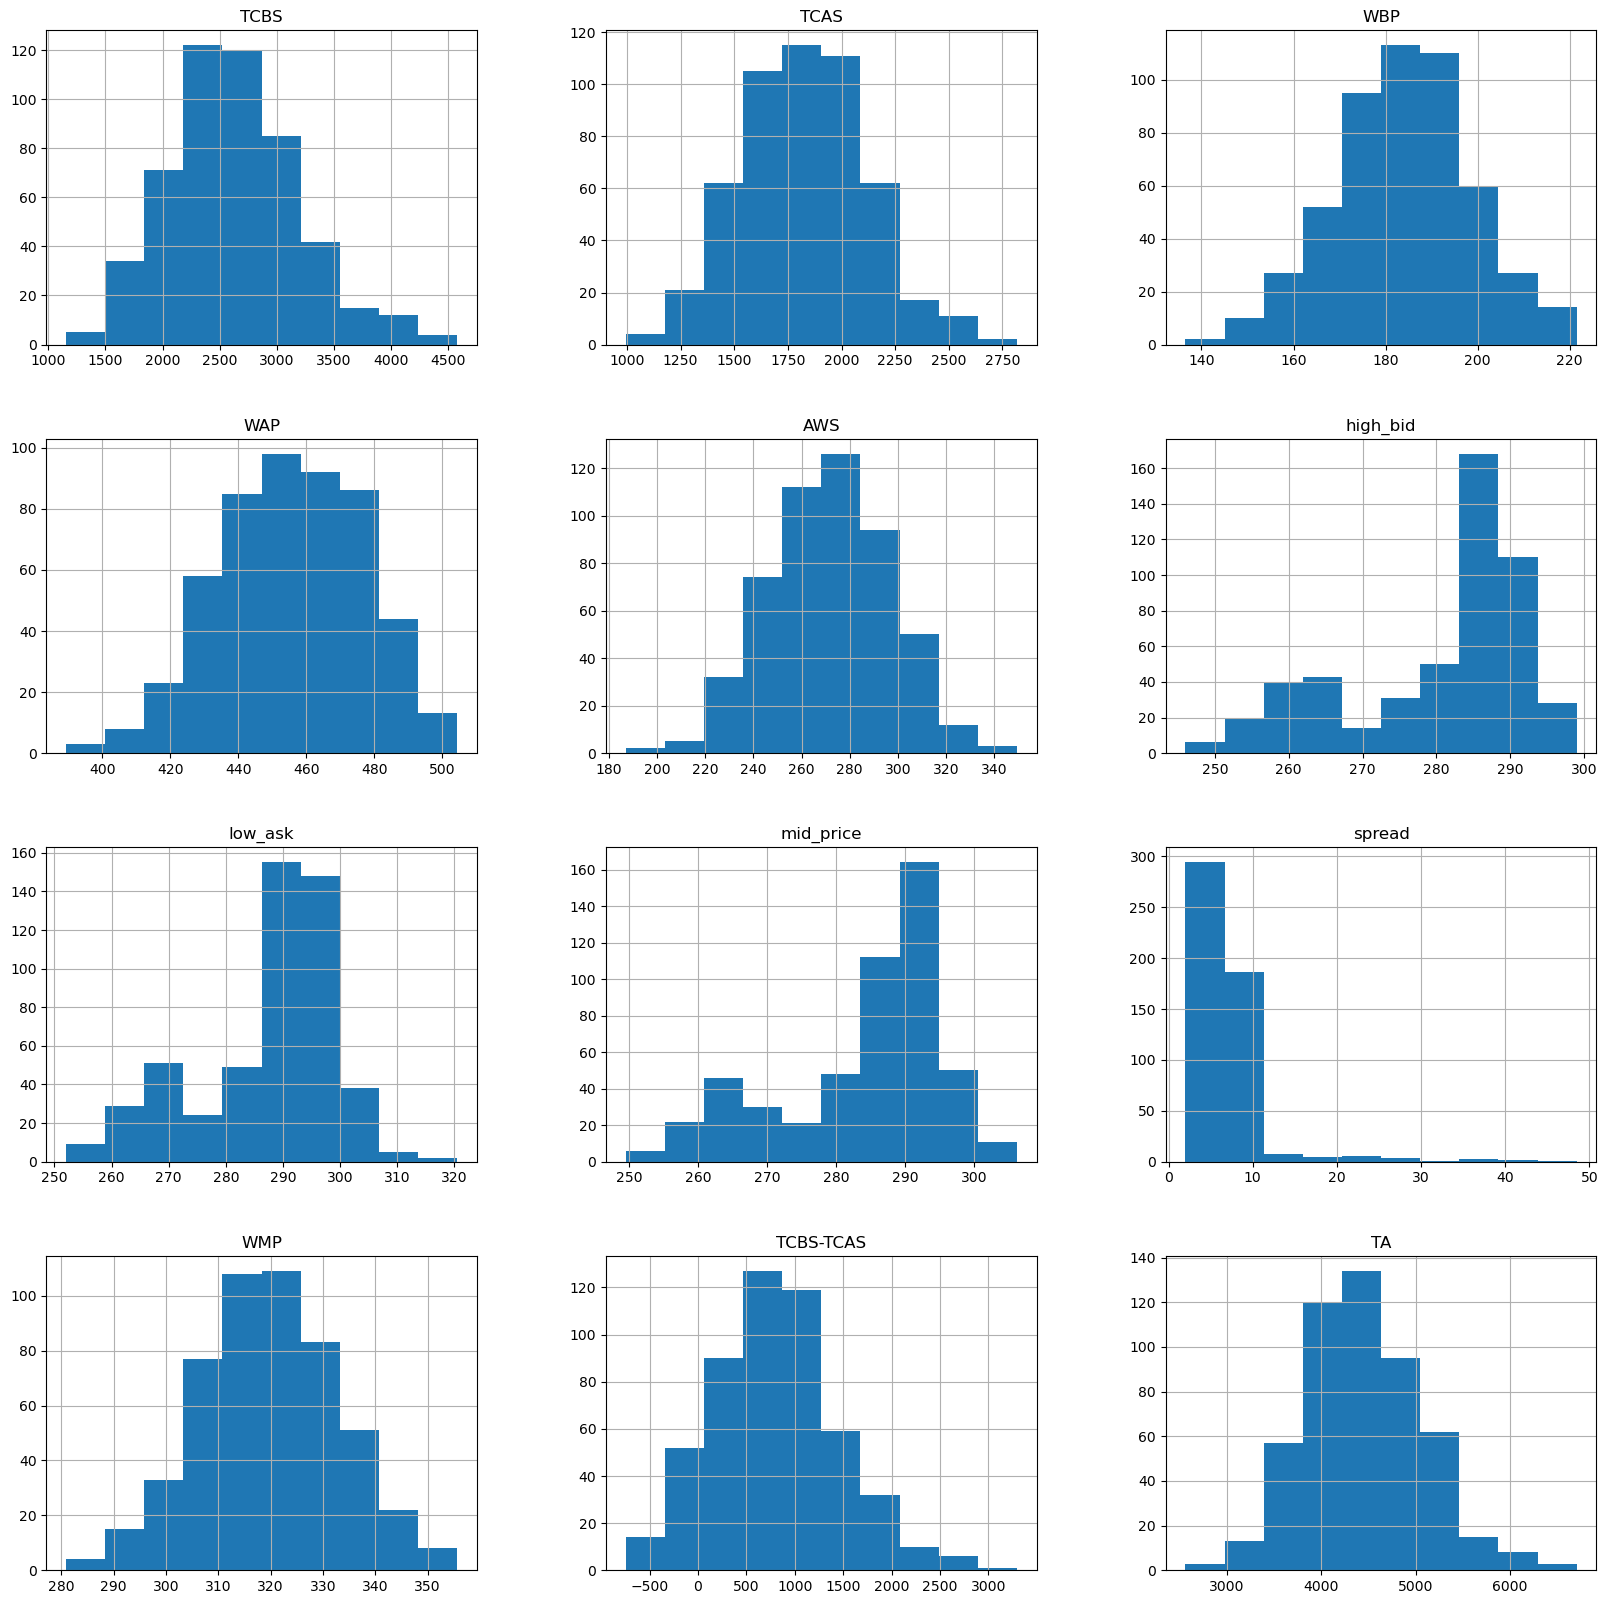

In [5]:
min_df.hist(figsize=(20,20))
plt.show()

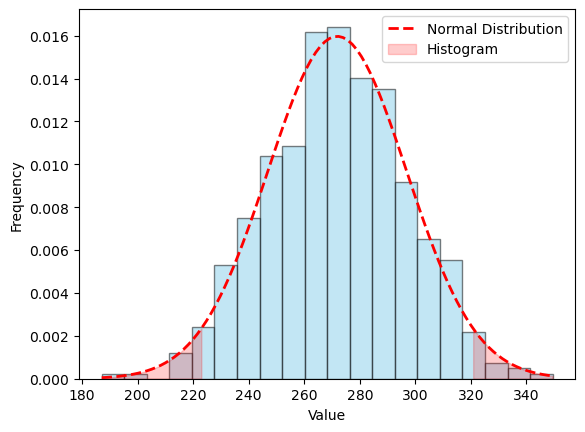

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Assuming you have imported min_df and plt.hist(min_df["AWS"], bins=20) elsewhere

# Plot the histogram
plt.hist(min_df["AWS"], bins=20, density=True, alpha=0.5, color='skyblue', edgecolor='black')

# Calculate mean and standard deviation of the data
mean = min_df["AWS"].mean()
std_dev = min_df["AWS"].std()

# Generate data points for the normal distribution curve
x = np.linspace(min_df["AWS"].min(), min_df["AWS"].max(), 100)
y = norm.pdf(x, mean, std_dev)

# Plot the normal distribution curve
plt.plot(x, y, color='red', linestyle='--', linewidth=2)

# Calculate critical values for the lower and upper tails
lower_critical_value = norm.ppf(0.025, mean, std_dev)
upper_critical_value = norm.ppf(0.975, mean, std_dev)

# Shade the area representing values with a 5% probability on both tails
x_shade_lower = np.linspace(min_df["AWS"].min(), lower_critical_value, 100)
x_shade_upper = np.linspace(upper_critical_value, min_df["AWS"].max(), 100)
plt.fill_between(x_shade_lower, norm.pdf(x_shade_lower, mean, std_dev), color='red', alpha=0.2)
plt.fill_between(x_shade_upper, norm.pdf(x_shade_upper, mean, std_dev), color='red', alpha=0.2)

# Add legend and labels
plt.legend(['Normal Distribution', 'Histogram'])
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()


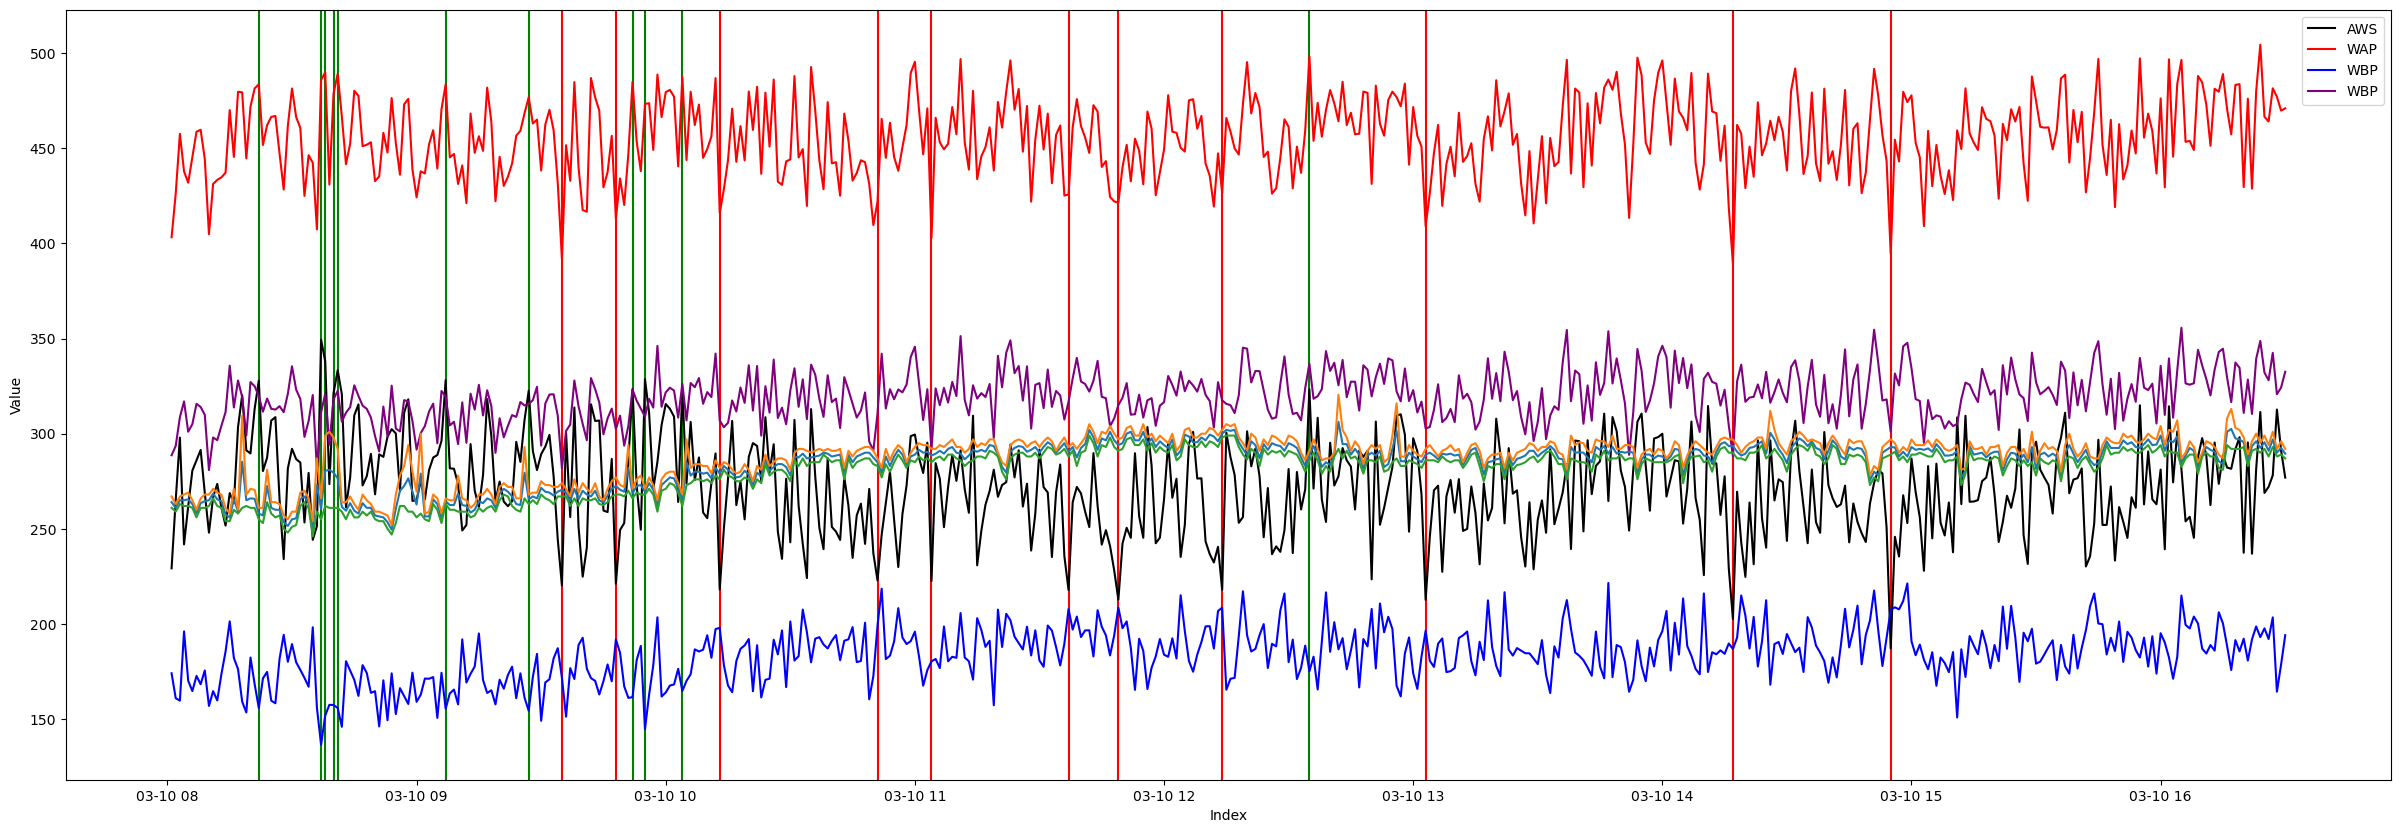

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Assuming you have imported min_df elsewhere

# Calculate mean and standard deviation of the data
mean = min_df["AWS"].mean()
std_dev = min_df["AWS"].std()

# Calculate critical values for the lower and upper tails
lower_critical_value = norm.ppf(0.025, mean, std_dev)
upper_critical_value = norm.ppf(0.975, mean, std_dev)

# Find the points within the tails
points_in_lower_tail = min_df["AWS"][min_df["AWS"] < lower_critical_value]
points_in_upper_tail = min_df["AWS"][min_df["AWS"] > upper_critical_value]

plt.figure(figsize=(30,10))
# Plot the line plot of min_df["AWS"]
for p in points_in_lower_tail.index:
    plt.axvline(p, color="red")

for p in points_in_upper_tail.index:
    plt.axvline(p, color="green")

    
plt.plot(min_df["AWS"], color='black', label='AWS')
plt.plot(min_df["WAP"], color='red', label='WAP')
plt.plot(min_df["WBP"], color='blue', label='WBP')
plt.plot(min_df["WMP"], color='purple', label='WBP')
plt.plot(min_df["mid_price"])
plt.plot(min_df["low_ask"])
plt.plot(min_df["high_bid"])

# Highlight points in the lower tail
#plt.scatter(points_in_lower_tail.index, points_in_lower_tail, color='red', label='Lower Tail')

# Highlight points in the upper tail
#plt.scatter(points_in_upper_tail.index, points_in_upper_tail, color='green', label='Upper Tail')



# Add legend and labels
plt.legend()
plt.xlabel('Index')
plt.ylabel('Value')

# Show the plot
plt.show()


In [10]:
import seaborn as sns

x_features = list(min_df)
y_feat = "mid_price"
x_features.remove("low_ask")
x_features.remove("high_bid")

sns.pairplot(min_df[x_features], hue = y_feat)

KeyboardInterrupt: 